# Feature engineering

## File structure

This project assumes the following initial file structure:

```bash
./feature_engineering                         
|   preprocessing.ipynb                       
|                                             
\---datasets                                  
    |                                         
    +---EmoDB                                 
    |   |   erkennung.txt                     
    |   |   erklaerung.txt                    
    |   |                                     
    |   +---lablaut                           
    |   |       ...                           
    |   |                                     
    |   +---labsilb                           
    |   |       ...                           
    |   |                                     
    |   +---silb                              
    |   |       ...                           
    |   |                                     
    |   \---wav                               
    |           03a01Fa.wav                   
    |           03a01Nc.wav                   
    |           ...                           
    |                                         
    \---RAVDESS                               
        |                                     
        +---song                              
        |   +---Actor_01                      
        |   |       03-02-01-01-01-01-01.wav  
        |   |       03-02-01-01-01-02-01.wav  
        |   |       ...                       
        |   |                                 
        |   +---Actor_02                      
        |   |       03-02-01-01-01-01-02.wav  
        |   |       03-02-01-01-01-02-02.wav  
        |   |       ...                       
        |   |                                 
        |   +---...                           
        |   \---Actor_24                      
        |           03-02-01-01-01-01-24.wav  
        |           03-02-01-01-01-02-24.wav  
        |           ...                       
        |                                     
        \---speech                            
            +---Actor_01                      
            |       03-01-01-01-01-01-01.wav  
            |       03-01-01-01-01-02-01.wav  
            |       ...                       
            +---Actor_02                      
            |       03-01-01-01-01-01-02.wav  
            |       03-01-01-01-01-02-02.wav  
            |       ...                       
            |                                 
            +---...                           
            \---Actor_24                      
                    03-01-01-01-01-01-24.wav  
                    03-01-01-01-01-02-24.wav  
                    ...                       
```

## Modules

### Imports

In [1]:
import csv
import importlib.metadata
import os
import types
from typing import Dict, List, Tuple

import librosa  # https://github.com/librosa/librosa/issues/1776
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

### Versions

The current module versions in use are as follows:

In [2]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name


imports = list(set(get_imports()))

requirements = []
for dist in importlib.metadata.distributions():
    if (
        dist.metadata["Name"].lower() in imports
        and dist.metadata["Name"].lower() != "pip"
    ):
        requirements.append((dist.metadata["Name"], dist.version))

pd.DataFrame(requirements, columns=["Module", "Version"])

,Module,Version
0,librosa,0.10.2.post1
1,matplotlib,3.9.2
2,numpy,1.26.4
3,pandas,2.2.3
4,tqdm,4.66.6


## Global variables

In [3]:
DATA_PATH = "./datasets"
SR = 8000
SEGMENT_DURATION = 3
PAD_ZERO = True
TRUNCATE = True
RAVDESS_PATH = os.path.join(DATA_PATH, "RAVDESS")
CODED_RAVDESS = {
    "modalities": {"01": "full-AV", "02": "video-only", "03": "audio-only"},
    "vocal_channels": {"01": "speech", "02": "song"},
    "emotions": {
        "01": "neutral",
        "02": "calm",
        "03": "happy",
        "04": "sad",
        "05": "angry",
        "06": "fearful",
        "07": "disgust",
        "08": "surprised",
    },
    "emotional_intensities": {"01": "normal", "02": "strong"},
    "statements": {
        "01": "Kids are talking by the door",
        "02": "Dogs are sitting by the door",
    },
    "repetitions": {"01": "1st repetition", "02": "2nd repetition"},
}
EMODB_PATH = os.path.join(DATA_PATH, "EmoDB")
CODED_EMODB = {
    "actors": {
        "03": ("Male", 31),
        "08": ("Female", 34),
        "09": ("Female", 21),
        "10": ("Male", 32),
        "11": ("Male", 26),
        "12": ("Male", 30),
        "13": ("Female", 32),
        "14": ("Female", 35),
        "15": ("Male", 25),
        "16": ("Female", 31),
    },
    "texts": {
        "a01": "Der Lappen liegt auf dem Eisschrank.",
        "a02": "Das will sie am Mittwoch abgeben.",
        "a04": "Heute abend könnte ich es ihm sagen.",
        "a05": "Das schwarze Stück Papier befindet sich da oben neben dem Holzstück.",
        "a07": "In sieben Stunden wird es soweit sein.",
        "b01": "Was sind denn das für Tüten, die da unter dem Tisch stehen?",
        "b02": "Sie haben es gerade hochgetragen und jetzt gehen sie wieder runter.",
        "b03": "An den Wochenenden bin ich jetzt immer nach Hause gefahren und habe Agnes besucht.",
        "b09": "Ich will das eben wegbringen und dann mit Karl was trinken gehen.",
        "b10": "Die wird auf dem Platz sein, wo wir sie immer hinlegen.",
    },
    "emotions": {
        "W": "Anger",
        "L": "Boredom",
        "E": "Disgust",
        "A": "Anxiety/Fear",
        "F": "Happiness",
        "T": "Sadness",
        "N": "Neutral",
    },
}
CHUNK_SIZE = 10
RANDOM_STATE = 42
TEST_SIZE = 0.2

## Feature engineering functions

In [4]:
def separate_vocals(
    speech: np.ndarray,
    sr: int = SR,
    filter_duration: float = 0.75,
    top_db: int = 60,
) -> np.ndarray:
    S_full, phase = librosa.magphase(librosa.stft(speech))
    S_filter = librosa.decompose.nn_filter(
        S_full,
        aggregate=np.median,
        metric="cosine",
        width=int(librosa.time_to_frames(filter_duration, sr=sr)),
    )
    S_filter = np.minimum(S_full, S_filter)
    mask_v = librosa.util.softmask(S_full - S_filter, 10 * S_filter, power=2)
    speech = librosa.istft(mask_v * S_full * phase)
    indexes = librosa.effects.split(speech, top_db=top_db)
    speech = np.array(
        [num for arr in (speech[i[0] : i[1]] for i in indexes) for num in arr.tolist()]
    )

    return speech

In [5]:
def read_ravdess(
    ravdess_path: str = RAVDESS_PATH,
    sr: int = SR,
    segment_duration: float = SEGMENT_DURATION,
    filter_duration: float = 0.75,
    top_db: int = 60,
    pad_zero: bool = PAD_ZERO,
    truncate: bool = TRUNCATE,
    coded_ravdess: Dict = CODED_RAVDESS,
    persistency: bool = True,
) -> Tuple[pd.DataFrame, List]:

    if persistency:
        with open(os.path.join(ravdess_path, "data.tsv"), mode="w") as f:
            f.truncate()

    data = {
        "File Name": [],
        "Duration": [],
        "Modality": [],
        "Vocal Channel": [],
        "Emotion": [],
        "Emotional Intensity": [],
        "Statement": [],
        "Repetition": [],
        "Sex": [],
    }
    file_paths = [
        os.path.join(root, file)
        for root, _, files in os.walk(ravdess_path)
        for file in files
        if file.endswith(".wav")
    ]
    for file_path in tqdm(file_paths):
        file_name = os.path.basename(file_path)
        duration = segment_duration if truncate else None
        speech, sr = librosa.load(file_path, sr=sr, mono=True, duration=duration)
        speech = separate_vocals(speech, sr, filter_duration, top_db)
        if pad_zero and len(speech) < segment_duration * sr:
            padding_length = segment_duration * sr - len(speech)
            speech = np.pad(speech, (0, padding_length), mode="constant", constant_values=0.0)

        if persistency:
            emotion = int(file_name[6:8])
            with open(os.path.join(ravdess_path, "data.tsv"), mode="a", newline="") as persist_file:
                tsv_writer = csv.writer(persist_file, delimiter="\t")
                tsv_writer.writerow([emotion] + np.round(speech, 7).tolist())

        data["File Name"].append(file_name[:-4])
        data["Duration"].append(len(speech) / sr)
        data["Modality"].append(coded_ravdess["modalities"].get(file_name[:2]))
        data["Vocal Channel"].append(coded_ravdess["vocal_channels"].get(file_name[3:5]))
        data["Emotion"].append(coded_ravdess["emotions"].get(file_name[6:8]))
        data["Emotional Intensity"].append(coded_ravdess["emotional_intensities"].get(file_name[9:11]))
        data["Statement"].append(coded_ravdess["statements"].get(file_name[12:14]))
        data["Repetition"].append(coded_ravdess["repetitions"].get(file_name[15:17]))
        data["Sex"].append("Male" if int(file_name[18:20]) % 2 else "Female")

    info = pd.DataFrame(data)

    if persistency:
        info.to_csv(os.path.join(ravdess_path, "info.csv"), index=False)

    return info

In [6]:
def read_emodb(
    emodb_path: str = EMODB_PATH,
    sr: int = SR,
    segment_duration: float = SEGMENT_DURATION,
    filter_duration: float = 0.5,
    top_db: int = 60,
    pad_zero: bool = PAD_ZERO,
    truncate: bool = TRUNCATE,
    coded_emodb: Dict = CODED_EMODB,
    persistency: bool = True,
) -> Tuple[pd.DataFrame, List]:
    if persistency:
        with open(os.path.join(emodb_path, "data.tsv"), mode="w") as f:
            f.truncate()

    data = {
        "File Name": [],
        "Duration": [],
        "Sex": [],
        "Age": [],
        "Text": [],
        "Emotion": [],
    }
    file_paths = [
        os.path.join(root, file)
        for root, _, files in os.walk(emodb_path)
        for file in files
        if file.endswith(".wav")
    ]
    for file_path in tqdm(file_paths):
        file_name = os.path.basename(file_path)
        duration = segment_duration if truncate else None
        speech, sr = librosa.load(file_path, sr=sr, mono=True, duration=duration)
        speech = separate_vocals(speech, sr, filter_duration, top_db)
        if pad_zero and len(speech) < segment_duration * sr:
            padding_length = segment_duration * sr - len(speech)
            speech = np.pad(
                speech, (0, padding_length), mode="constant", constant_values=0.0
            )

        if persistency:
            emotion = (
                list(coded_emodb["emotions"].keys()).index(file_name[5])
                if file_name[5] in coded_emodb["emotions"]
                else -1
            )
            with open(os.path.join(emodb_path, "data.tsv"), mode="a", newline="") as persist_file:
                tsv_writer = csv.writer(persist_file, delimiter="\t")
                tsv_writer.writerow([emotion] + np.round(speech, 7).tolist())

        data["File Name"].append(file_name[:-4])
        data["Duration"].append(len(speech) / sr)
        data["Sex"].append(coded_emodb["actors"].get(file_name[:2], [None, None])[0])
        data["Age"].append(coded_emodb["actors"].get(file_name[:2], [None, None])[1])
        data["Text"].append(file_name[2:5])
        data["Emotion"].append(coded_emodb["emotions"].get(file_name[5]))

    info = pd.DataFrame(data)

    if persistency:
        info.to_csv(os.path.join(emodb_path, "info.csv"), index=False)

    return info

## Main

### RAVDESS

In [ ]:
preliminary = False

In [ ]:
if preliminary:
    ravdess_info = read_ravdess(pad_zero=False, truncate=False, persistency=False)

In [ ]:
if preliminary:
    ravdess_info.describe()

In [ ]:
if preliminary:
    plt.figure(figsize=(5, 5), dpi=80)

    plt.boxplot(ravdess_info["Duration"], showmeans=True)

    plt.title("Distribution of RAVDESS Durations", fontsize=16, weight="bold")
    plt.xlabel("RAVDESS Data", fontsize=14)
    plt.ylabel("Duration (seconds)", fontsize=14)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks([1], ["Durations"], fontsize=12)

    plt.tight_layout()

    plt.savefig(os.path.join(RAVDESS_PATH, "Durations Box Plot.png"))
    plt.show()

![Durations Box Plot](<.\datasets\RAVDESS\Durations Box Plot.png>)

In [ ]:
if preliminary:
    plt.figure(figsize=(7, 5), dpi=80)

    ravdess_info["Emotion"].value_counts().plot.bar(rot=0)

    plt.title("Distribution of RAVDESS Emotions", fontsize=16, weight="bold")
    plt.ylabel("Count", fontsize=14)

    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()

    plt.savefig(os.path.join(RAVDESS_PATH, "Count plot.png"))
    plt.show()

![Count Plot.png](<.\datasets\RAVDESS\Count Plot.png>)

In [ ]:
if not preliminary:
    ravdess_info = read_ravdess(segment_duration=3)

In [ ]:
if not preliminary:
    chunks = pd.read_csv(
        os.path.join(RAVDESS_PATH, "data.tsv"),
        header=None,
        sep="\t",
        chunksize=CHUNK_SIZE,
    )

    chunk_list = []
    for chunk in tqdm(chunks):
        chunk_list.append(chunk)

    data = pd.concat(chunk_list, axis=0)

    train_data, test_data = train_test_split(
        data, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data.iloc[:, 0]
    )

    train_data.to_csv(
        os.path.join(RAVDESS_PATH, "RAVDESS_TRAIN.tsv"),
        sep="\t",
        index=False,
        header=False,
        chunksize=CHUNK_SIZE,
    )
    test_data.to_csv(
        os.path.join(RAVDESS_PATH, "RAVDESS_TEST.tsv"),
        sep="\t",
        index=False,
        header=False,
        chunksize=CHUNK_SIZE,
    )

### EmoDB

In [ ]:
preliminary = False

In [ ]:
if preliminary:
    emodb_info = read_emodb(pad_zero=False, truncate=False, persistency=False)

In [ ]:
if preliminary:
    emodb_info.describe()

In [ ]:
if preliminary:
    plt.figure(figsize=(5, 5), dpi=80)

    plt.boxplot(emodb_info["Duration"], showmeans=True)

    plt.title("Distribution of EmoDB Durations", fontsize=16, weight="bold")
    plt.xlabel("EmoDB Data", fontsize=14)
    plt.ylabel("Duration (seconds)", fontsize=14)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks([1], ["Durations"], fontsize=12)

    plt.tight_layout()

    plt.savefig(os.path.join(EMODB_PATH, "Durations Box Plot.png"))
    plt.show()

![Durations Box Plot](<.\datasets\EmoDB\Durations Box Plot.png>)

In [ ]:
if preliminary:
    plt.figure(figsize=(7, 5), dpi=80)

    emodb_info["Emotion"].value_counts().plot.bar(rot=0)

    plt.title("Distribution of EmoDB Emotions", fontsize=16, weight="bold")
    plt.ylabel("Count", fontsize=14)

    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()

    plt.savefig(os.path.join(EMODB_PATH, "Count plot.png"))
    plt.show()

![Count plot.png](<.\datasets\EmoDB\Count Plot.png>)

In [ ]:
if not preliminary:
    emodb_info = read_emodb(segment_duration=3)

In [ ]:
if not preliminary:
    chunks = pd.read_csv(
        os.path.join(EMODB_PATH, "data.tsv"),
        header=None,
        sep="\t",
        chunksize=CHUNK_SIZE,
    )

    chunk_list = []
    for chunk in tqdm(chunks):
        chunk_list.append(chunk)

    data = pd.concat(chunk_list, axis=0)

    train_data, test_data = train_test_split(
        data, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data.iloc[:, 0]
    )

    train_data.to_csv(
        os.path.join(EMODB_PATH, "EmoDB_TRAIN.tsv"),
        sep="\t",
        index=False,
        header=False,
        chunksize=CHUNK_SIZE,
    )
    test_data.to_csv(
        os.path.join(EMODB_PATH, "EmoDB_TEST.tsv"),
        sep="\t",
        index=False,
        header=False,
        chunksize=CHUNK_SIZE,
    )

## Multivariate feature engineering

In [7]:
def load_inertial_signals(folder_path, train=True):
    if train == True:
        signal_files = [
            "body_acc_x_train.txt",
            "body_acc_y_train.txt",
            "body_acc_z_train.txt",
            "body_gyro_x_train.txt",
            "body_gyro_y_train.txt",
            "body_gyro_z_train.txt",
        ]
    else:
        signal_files = [
            "body_acc_x_test.txt",
            "body_acc_y_test.txt",
            "body_acc_z_test.txt",
            "body_gyro_x_test.txt",
            "body_gyro_y_test.txt",
            "body_gyro_z_test.txt",
        ]

    signals = {}

    for file in signal_files:
        signal_name = (
            file.split("_")[1] + "_" + file.split("_")[2]
        )  # body_acc, body_gyro, etc.
        file_path = folder_path + "/" + file

        if os.path.exists(file_path):
            # Read the signal file into a DataFrame
            signal_data = pd.read_csv(
                file_path, header=None, sep=r"\s+", engine="python"
            )
            signals[signal_name] = signal_data
        else:
            print(f"File {file_path} not found!")

    return signals


def load_labels(label_file_path):
    labels = pd.read_csv(label_file_path, header=None)
    return labels.to_numpy().flatten()


def save_time_series_to_ts_file(data, labels, output_file):
    with open(output_file, "w") as f:
        f.write(
            "@problemName HAR\n@timeStamps false\n@missing false\n@univariate false\n@dimensions 6\n@equalLength false\n@classLabel true 1 2 3 4 5 6\n@data"
        )
        features = list(data.keys())
        n = len(data[features[0]])
        for i in range(n):
            series_data_point = []
            for feat in features:
                series = data[feat].iloc[i]
                # join data in a string
                joined_string = ",".join(map(str, series))
                series_data_point.append(joined_string)
            # write row to file
            formatted_row = ":".join(map(str, series_data_point)) + f":{labels[i]}\n"
            f.write(formatted_row)

In [8]:
# Define paths
root = "datasets/HAR/"
train_signals_folder = root + "train/Inertial Signals"
test_signals_folder = root + "test/Inertial Signals"
train_labels_file = root + "train/y_train.txt"
test_labels_file = root + "test/y_test.txt"

# save training data
train_signals = load_inertial_signals(train_signals_folder, train=True)
train_labels = load_labels(train_labels_file)
save_time_series_to_ts_file(train_signals, train_labels, root + "HAR_TRAIN.ts")

# save testing data
test_signals = load_inertial_signals(test_signals_folder, train=False)
test_labels = load_labels(test_labels_file)
save_time_series_to_ts_file(test_signals, test_labels, root + "HAR_TEST.ts")

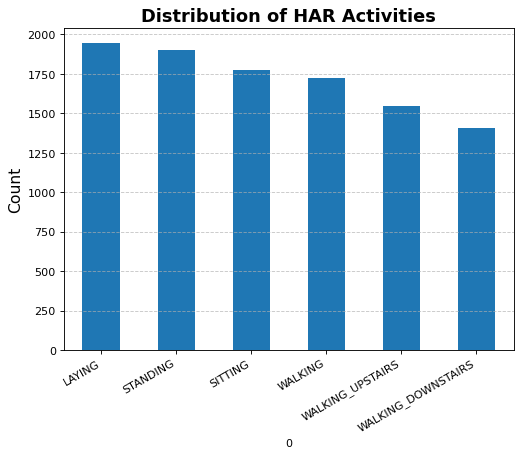

In [35]:
activities = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING",
}

plt.figure(figsize=(7, 5), dpi=80)

labels = pd.DataFrame(
    [
        activities[int(line.strip().split(":")[-1])]
        for line in open("datasets/HAR/HAR_TEST.ts", "r")
        if line.strip() and not line.strip().startswith("@")
    ]
    + [
        activities[int(line.strip().split(":")[-1])]
        for line in open("datasets/HAR/HAR_TRAIN.ts", "r")
        if line.strip() and not line.strip().startswith("@")
    ]
)

labels[0].value_counts().plot.bar(rot=0)

plt.title("Distribution of HAR Activities", fontsize=16, weight="bold")
plt.ylabel("Count", fontsize=14)

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()

plt.xticks(rotation=30, ha="right")
plt.savefig(os.path.join(EMODB_PATH, "Count plot.png"))
plt.show()

In [34]:
    [
        activities[int(line.strip().split(":")[-1])]
        for line in open("datasets/HAR/HAR_TEST.ts", "r")
        if line.strip() and not line.strip().startswith("@")
    ] + [
            activities[int(line.strip().split(":")[-1])]
            for line in open("datasets/HAR/HAR_TRAIN.ts", "r")
            if line.strip() and not line.strip().startswith("@")
        ]

['STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'STANDING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'SITTING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'LAYING',
 'WALKING',
 'WALKING',
 'WALKING',
 'WALKING',
 'WALKING'